In [ ]:
import os
import sys

from cascade.cascade2p import cascade  # local folder
from cascade.cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth
from cascade.cascade2p import checks

import numpy as np
import h5py
import scipy.io as sio
import ruamel.yaml as yaml

import matplotlib.pyplot as plt

from scripts.sample_db import SampleDB

from scripts.utils.traces_utils import load_hdf5_data

In [ ]:

# from os import listdir
if 'Demo scripts' in os.getcwd():
    sys.path.append(os.path.abspath('..'))  # add parent directory to path for imports
    os.chdir('..')  # change to main directory
print('Current working directory: {}'.format(os.getcwd()))

checks.check_packages()

os.chdir('D:\montruth\PycharmProjects\samplePy\cascade')


# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)

# Loading experiment
sample_id = '20220427_RM0008_126hpf_fP3_f3'  
exp = sample_db.get_sample(sample_id)
print(exp.sample.id)

# Path to the HDF5 file
hdf5_file_path = f'{exp.paths.trials_path}/traces/{exp.sample.id}_fluorescence_data.h5'

# Load the data
data = load_hdf5_data(hdf5_file_path, exp.sample.id)
dff_traces = data['dff_traces']

print(f"Loaded {dff_traces.shape[0]} traces with {dff_traces.shape[1]} timepoints each.")

cascade.download_model('update_models', verbose=1)

yaml_file = open('Pretrained_models/available_models.yaml')
X = yaml.load(yaml_file, Loader=yaml.Loader)
list_of_models = list(X.keys())

for model in list_of_models:
    print(model)

# %% Select pretrained model
model_name = 'Global_EXC_7.5Hz_smoothing200ms'
cascade.download_model(model_name, verbose=1)


In [ ]:

traces = dff_traces
print('Number of neurons in dataset:', traces.shape[0])
print('Number of timepoints in dataset:', traces.shape[1])

frame_rate = exp.params_lm.sampling_hz/exp.params_lm.n_planes
print('Frame rate:', frame_rate)
noise_levels = plot_noise_level_distribution(traces, frame_rate)

# np.random.seed(3952)
neuron_indices = np.random.randint(traces.shape[0], size=10)
plot_dFF_traces(traces, neuron_indices, frame_rate)

In [6]:
# Perform spike inference
spike_prob = cascade.predict(model_name, dff_traces)


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 7.5Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 200 milliseconds. 
 

Loaded model was trained at frame rate 7.5 Hz
Given argument traces contains 58083 neurons and 375 frames.
Noise levels (mean, std; in standard units): 0.01, 0.0

Predictions for noise level 2:
	... ensemble 0
2659/2659 [==============================] - 171s 64ms/step
	... ensemble 1
2659/2659 [==============================] - 164s 62ms/step
	... ensemble 2
2659/2659 [==============================] - 166s 62ms/step
	... ensemble 3
2659/2659 [==============================] - 165s 62ms/step
	... ensemble 4
2659/2659 [==============================] - 157s 59ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise

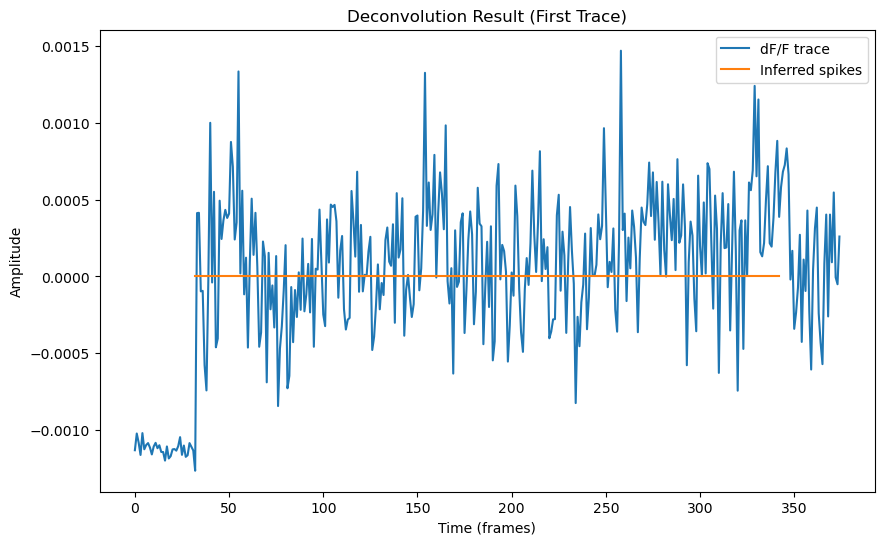

Deconvolved traces saved in HDF5 file.


In [7]:
# Plot results for the first trace
plt.figure(figsize=(10, 6))
plt.plot(dff_traces[0], label='dF/F trace')
plt.plot(spike_prob[0], label='Inferred spikes')
plt.legend()
plt.title('Deconvolution Result (First Trace)')
plt.xlabel('Time (frames)')
plt.ylabel('Amplitude')
plt.show()

# Save deconvolved traces
with h5py.File(hdf5_file_path, 'r+') as f:
    exp_grp = f[exp.sample.id]
    if 'deconvolved_spikes' in exp_grp:
        del exp_grp['deconvolved_spikes']
    exp_grp.create_dataset('deconvolved_spikes', data=spike_prob)

print("Deconvolved traces saved in HDF5 file.")

C:\ProgramData\mambaforge\envs\cascade-env\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


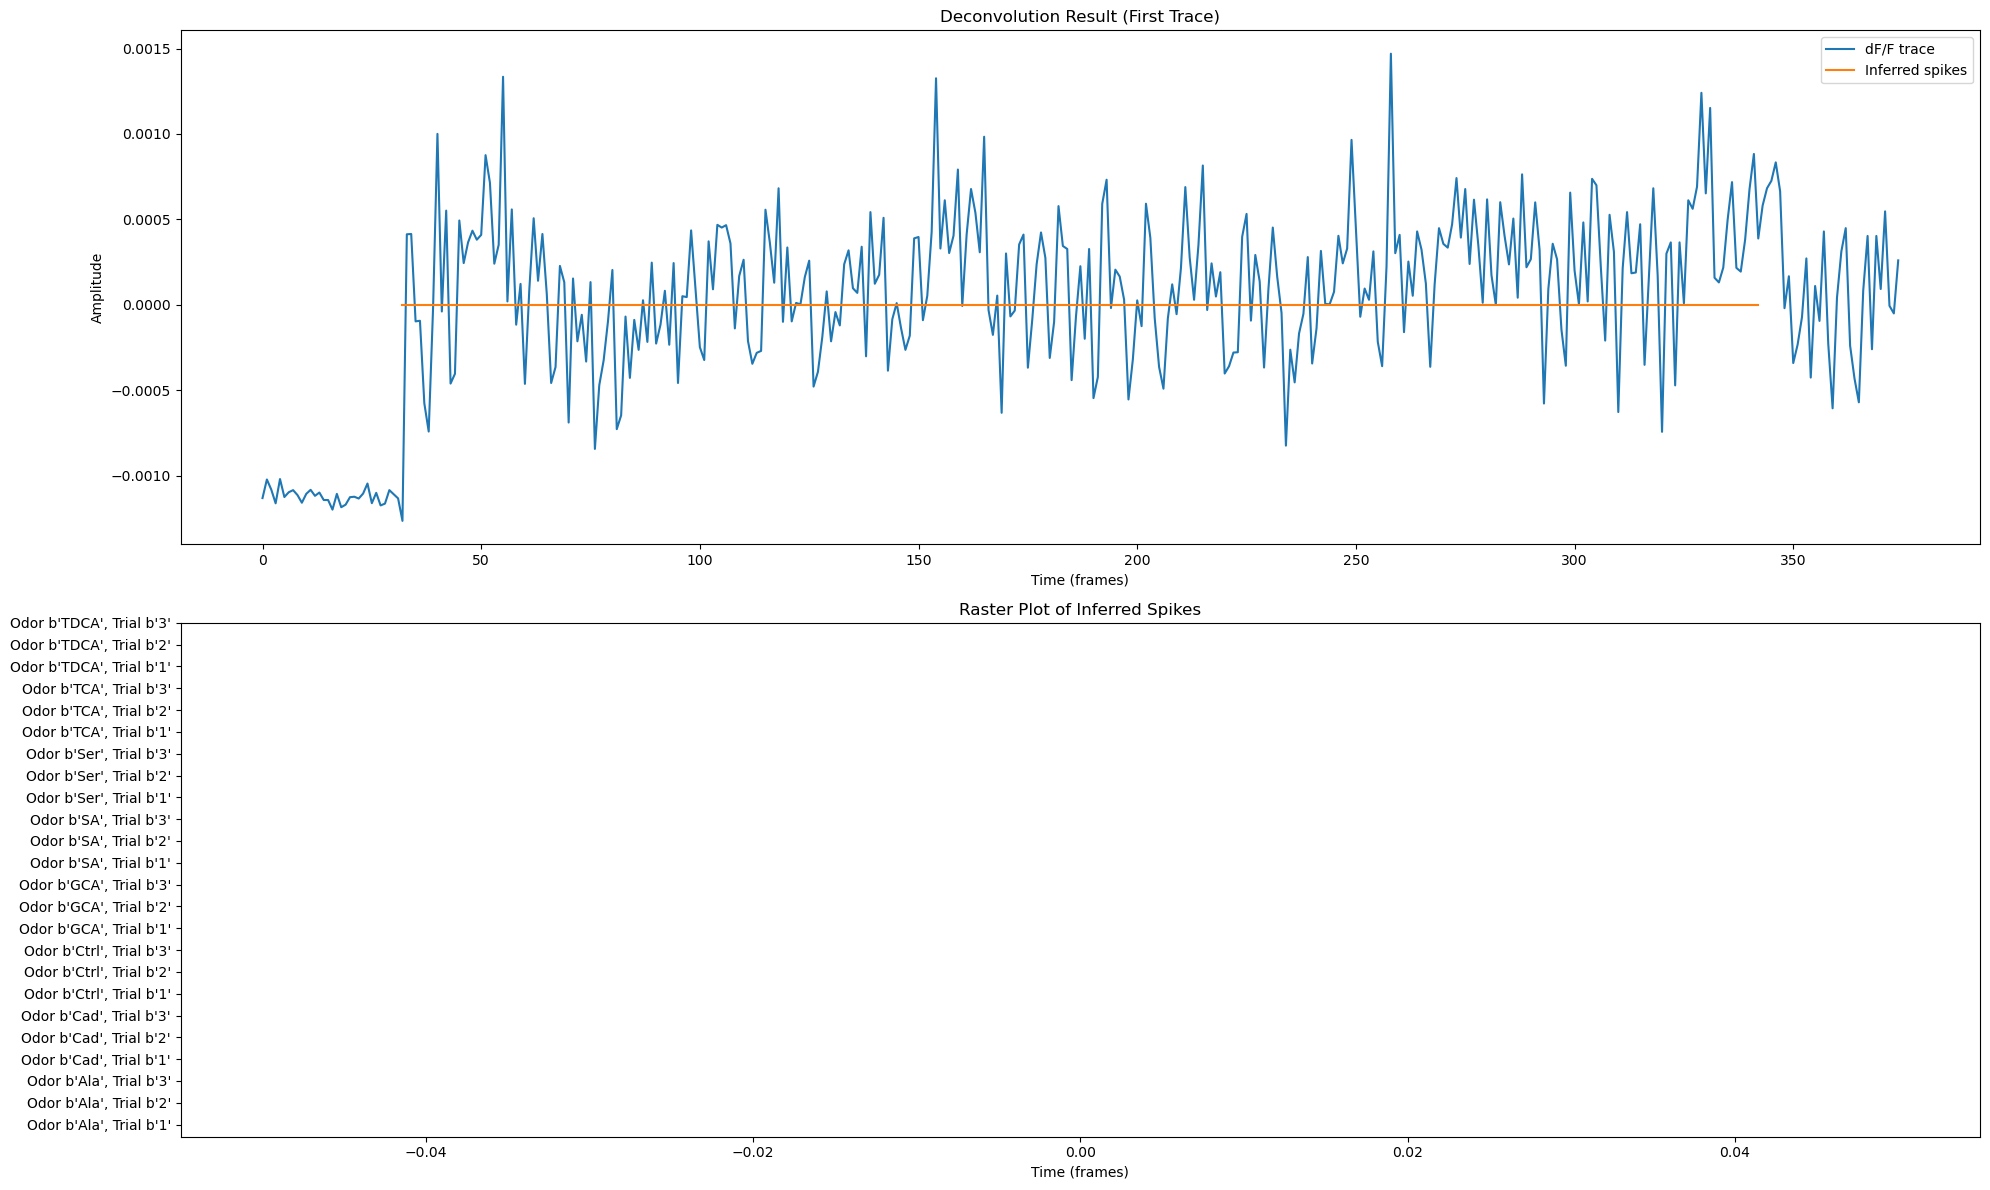

In [11]:
# Load data from HDF5 file
with h5py.File(hdf5_file_path, 'r') as f:
    exp_grp = f[exp.sample.id]
    dff_traces = exp_grp['dff_traces'][()]
    spike_prob = exp_grp['deconvolved_spikes'][()]
    odors = exp_grp['odor'][()]
    trials = exp_grp['trial_nr'][()]

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# Plot deconvolution result for the first trace
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(dff_traces[0], label='dF/F trace')
ax1.plot(spike_prob[0], label='Inferred spikes')
ax1.legend()
ax1.set_title('Deconvolution Result (First Trace)')
ax1.set_xlabel('Time (frames)')
ax1.set_ylabel('Amplitude')

# Create raster plots
ax2 = fig.add_subplot(2, 1, 2)

unique_odors = np.unique(odors)
unique_trials = np.unique(trials)

for i, odor in enumerate(unique_odors):
    for j, trial in enumerate(unique_trials):
        mask = (odors == odor) & (trials == trial)
        spikes = spike_prob[mask]
        
        if spikes.size > 0:
            for k, spike_train in enumerate(spikes):
                spike_times = np.where(spike_train > 0.5)[0]  # Threshold at 0.5
                ax2.scatter(spike_times, 
                            np.ones_like(spike_times) * (i * len(unique_trials) + j), 
                            marker='|', s=10, c='black')

ax2.set_yticks(np.arange(len(unique_odors) * len(unique_trials)) + 0.5)
ax2.set_yticklabels([f'Odor {o}, Trial {t}' for o in unique_odors for t in unique_trials])
ax2.set_xlabel('Time (frames)')
ax2.set_title('Raster Plot of Inferred Spikes')

plt.tight_layout()
plt.show()